In [9]:
# from qiskit.opflow import I, Z, X, Y, SparsePauliOp
import numpy as np
# from juqcs import Juqcs
# 假设有 3 台机器和 3 个操作
m = 3 # 机器数量
n = 1  # 操作数量
l = 2  # 用于表示 C_max 的二进制位数

# 处理时间矩阵 (例如)
p = np.array([[1, 2, 1]])

# 常数
K1 = 10
K2 = 5

# 量子比特数量
num_qubits = m * n + l



In [10]:
#
def pauli_z_term(index, num_qubits):
    """初始化一个 Pauli-I 门的列表,指定索引 index 替换为 Pauli-Z 门"""
    paulis = ['I'] * num_qubits
    paulis[index] = 'Z'
    return ''.join(paulis)  # 将列表转化为字符串


$$\frac{1}{2} \sum_{h=0}^{l-1} 2^h - \frac{1}{2} \sum_{h=0}^{l-1} 2^h Z_{z_h}$$

$$\frac{1}{2}\left(2^l-1\right)-\frac{1}{2} \sum_{h=0}^{l-1} 2^h Z_{z_h}$$

In [11]:
from qiskit.quantum_info import Pauli, SparsePauliOp, PauliList

# 常数项
# constant_term = 1/2 * sum(2**h for h in range(l))
pauli_strings = []
cofficients = []
# 构建 Pauli-Z 项
z_terms = []
for h in range(l):
    coef = - 2**h / 2
    z_term = pauli_z_term(m * n + h, num_qubits)
    z_terms.append((coef, z_term))

# 从z_terms中提取Pauli字符串和系数
pauli_strings = [term[1] for term in z_terms]
coefficients = [term[0] for term in z_terms]
# 转换为 SparsePauliOp
paulis = [Pauli(label) for label in pauli_strings]
hamiltonian1 = SparsePauliOp.from_list(list(zip(pauli_strings, coefficients)))
print(hamiltonian1)

SparsePauliOp(['IIIZIIIIIII', 'IIIIZIIIIII'],
              coeffs=[-0.5+0.j, -1. +0.j])


$$K1\left(\sum_{i=1}^{n} \left( \frac{m}{2} - 1 \right)^2 -  \left( \frac{m}{2} - 1 \right)  \sum_{j=1}^{m} Z_{x_{ij}} + \frac{1}{4} \left( \sum_{j=1}^{m} Z_{x_{ij}} \right)^2\right)$$

$$K_1 \sum_{i=1}^n\left(\frac{(m-2)^2}{4}-\frac{(m-2)}{2} \sum_{j=1}^m Z_{x_{i j}}+\frac{1}{4}\left(\sum_{j=1}^m Z_{x_{i j}}\right)^2\right)$$

In [17]:
pauli_strings = []
cofficients = []
# 常数项
# constant_term1 = K1 * n * ((m / 2) - 1)**2
# pauli_strings.append('I'*num_qubits)
# cofficients.append(constant_term1)

# 线性项
x_terms = []
# coef_linear = -1 * K1 * (m / 2 - 1)
for i in range(n):
    for j in range(m):
        coef = -1 * K1 * (m - 1)/2
        x_term = pauli_z_term(i * m + j, num_qubits)
        pauli_strings.append(x_term)
        cofficients.append(coef)
        # linear_terms.append((coef, x_term))

# 二次项
# quadratic_terms = []
# coef_quadratic = K1 / 4
for i in range(n):
    coef = K1 / 4
    for j1 in range(m):
        for j2 in range(m):
            if j1 != j2:
                x_term1 = pauli_z_term(i * m + j1, num_qubits)
                x_term2 = pauli_z_term(i * m + j2, num_qubits)
                combined_op = ''.join(['I' if c1 == 'I' and c2 == 'I' else 'Z' if c1 == 'Z' or c2 == 'Z' else 'I'
                                           for c1, c2 in zip(x_term1, x_term2)])
                pauli_strings.append(combined_op)
                cofficients.append(coef)
            # quadratic_terms.append((coef, x_term1 + x_term2)) # 二次项的具体形式应该是每对 Zij 和 Zik 的组合

# 组合所有项
# pauli_strings = [term[1] for term in linear_terms + quadratic_terms]
# coefficients = [term[0] for term in linear_terms + quadratic_terms]
print(pauli_strings)
print(cofficients)
# 转换为 SparsePauliOp
paulis = [Pauli(label) for label in pauli_strings]
hamiltonian2 = SparsePauliOp.from_list(list(zip(pauli_strings, cofficients)))

print(hamiltonian2)


['ZIIIIIIIIII', 'IZIIIIIIIII', 'IIZIIIIIIII', 'ZZIIIIIIIII', 'ZIZIIIIIIII', 'ZZIIIIIIIII', 'IZZIIIIIIII', 'ZIZIIIIIIII', 'IZZIIIIIIII']
[-10.0, -10.0, -10.0, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5]
SparsePauliOp(['ZIIIIIIIIII', 'IZIIIIIIIII', 'IIZIIIIIIII', 'ZZIIIIIIIII', 'ZIZIIIIIIII', 'ZZIIIIIIIII', 'IZZIIIIIIII', 'ZIZIIIIIIII', 'IZZIIIIIIII'],
              coeffs=[-10. +0.j, -10. +0.j, -10. +0.j,   2.5+0.j,   2.5+0.j,   2.5+0.j,
   2.5+0.j,   2.5+0.j,   2.5+0.j])


$$K2\sum_{j=1}^{m} \left( \frac{1}{2} \sum_{i=1}^{n} p_{ij} - \frac{1}{2} \sum_{i=1}^{n} p_{ij} Z_{x_{ij}} + \frac{1}{2} \sum_{h=0}^{l-1} 2^h Z_{z_h} - \frac{1}{2} \sum_{h=0}^{l-1} 2^h Z{\tau_{jh}} \right)^2$$

\begin{aligned}
P\sum_{j=1}^m\left(\frac{1}{4}\left(\sum_{i=1}^n p_{i j}-\left(2^l-1\right)\right)^2-\frac{1}{2}\left(\sum_{i=1}^n p_{i j}-\left(2^l-1\right)\right)\left(\sum_{i=1}^n p_{i j} Z_{x_{i j}}-\sum_{h=0}^{l-1} 2^h Z_{z_h}\right)\right)\left.+\frac{1}{4}\left(\sum_{i=1}^n \sum_{k=1}^n p_{i j} p_{k j} Z_{x_{i j}} Z_{x_{k j}}-2 \sum_{i=1}^n \sum_{h=0}^{l-1} p_{i j} 2^h Z_{x_{i j}} Z_{z_h}+\sum_{h=0}^{l-1} \sum_{g=0}^{l-1} 2^{h+g} Z_{z_h} Z_{z_g}\right)\right)
\end{aligned}

In [22]:
# 初始化数组
pauli_strings = []
coefficients = []
x_terms = []
z_terms = []
# 线性和二次项
for j in range(m):
    # constant_term = -1/2*(np.sum(p[:, j]) - ( 2 ** l-1))
    # h_terms = []

    for i in range(n):
        coef =-1/2 * (np.sum(p[:, j]) - ( 2 ** l-1)) * p[i, j] * K2
        x_term = pauli_z_term(j * n + i, num_qubits)
        x_terms.append((coef, x_term))
        # pauli_strings.append(x_term)
        # cofficients.append(coef)

    for h in range(l):
        coef = -1/2 * (np.sum(p[:, j]) - ( 2 ** l-1)) * - 2 ** h * K2
        z_term = pauli_z_term(m * n + h, num_qubits)
        # pauli_strings.append(z_term)
        # cofficients.append(coef)
        x_terms.append((coef,z_term))

    for i1 in range(n):
        for i2 in range(n):
            if i1 != i2:
                coef = 1/4 * p[i1, j] * p[i2, j] * K2
                x_term1 = pauli_z_term(j * n + i1, num_qubits)
                x_term2 = pauli_z_term(j * n + i2, num_qubits)
                combined_op = ''.join(['I' if c1 == 'I' and c2 == 'I' else 'Z' if c1 == 'Z' or c2 == 'Z' else 'I'
                                           for c1, c2 in zip(x_term1, x_term2)])
                # pauli_strings.append(combined_op)
                # cofficients.append(coef)
                x_terms.append((coef, combined_op))
    for i in range(n):
        for h in range(l):
            coef = 1/4 * -2 * p[i,j] * 2 ** h * K2
            x_term = pauli_z_term(j * n + i, num_qubits)
            z_term = pauli_z_term(m * n + h, num_qubits)
            combined_op = ''.join(['I' if c1 == 'I' and c2 == 'I' else 'Z' if c1 == 'Z' or c2 == 'Z' else 'I'
                                           for c1, c2 in zip(x_term, z_term)])
            # pauli_strings.append(combined_op)
            # cofficients.append(coef)
            x_terms.append((coef, combined_op))
    for h1 in range(l):
        for h2 in range(l):
            if h1 != h2:
                coef = 1/4 * 2 ** h1 * 2 ** h2 * K2
                z_term1 = pauli_z_term(m * n + h1, num_qubits)
                z_term2= pauli_z_term(m * n + h2, num_qubits)
                combined_op = ''.join(['I' if c1 == 'I' and c2 == 'I' else 'Z' if c1 == 'Z' or c2 == 'Z' else 'I'
                                           for c1, c2 in zip(z_term1, z_term2)])
                # pauli_strings.append(combined_op)
                # cofficients.append(coef)
                x_terms.append((coef, combined_op))
pauli_strings = [term[1] for term in x_terms]
coefficients = [term[0] for term in x_terms]
# 转换为 SparsePauliOp
paulis = [Pauli(label) for label in pauli_strings]
hamiltonian3 = SparsePauliOp.from_list(list(zip(pauli_strings, coefficients)))

print(hamiltonian3)

SparsePauliOp(['ZIIIIIIIIII', 'IIIZIIIIIII', 'IIIIZIIIIII', 'ZIIZIIIIIII', 'ZIIIZIIIIII', 'IIIZZIIIIII', 'IIIZZIIIIII', 'IZIIIIIIIII', 'IIIZIIIIIII', 'IIIIZIIIIII', 'IZIZIIIIIII', 'IZIIZIIIIII', 'IIIZZIIIIII', 'IIIZZIIIIII', 'IIZIIIIIIII', 'IIIZIIIIIII', 'IIIIZIIIIII', 'IIZZIIIIIII', 'IIZIZIIIIII', 'IIIZZIIIIII', 'IIIZZIIIIII'],
              coeffs=[  5. +0.j,  -5. +0.j, -10. +0.j,  -2.5+0.j,  -5. +0.j,   2.5+0.j,
   2.5+0.j,   5. +0.j,  -2.5+0.j,  -5. +0.j,  -5. +0.j, -10. +0.j,
   2.5+0.j,   2.5+0.j,   5. +0.j,  -5. +0.j, -10. +0.j,  -2.5+0.j,
  -5. +0.j,   2.5+0.j,   2.5+0.j])


In [23]:
hamiltonian = hamiltonian1+hamiltonian2+hamiltonian3
print(hamiltonian)

SparsePauliOp(['IIIZIIIIIII', 'IIIIZIIIIII', 'ZIIIIIIIIII', 'IZIIIIIIIII', 'IIZIIIIIIII', 'ZZIIIIIIIII', 'ZIZIIIIIIII', 'ZZIIIIIIIII', 'IZZIIIIIIII', 'ZIZIIIIIIII', 'IZZIIIIIIII', 'ZIIIIIIIIII', 'IIIZIIIIIII', 'IIIIZIIIIII', 'ZIIZIIIIIII', 'ZIIIZIIIIII', 'IIIZZIIIIII', 'IIIZZIIIIII', 'IZIIIIIIIII', 'IIIZIIIIIII', 'IIIIZIIIIII', 'IZIZIIIIIII', 'IZIIZIIIIII', 'IIIZZIIIIII', 'IIIZZIIIIII', 'IIZIIIIIIII', 'IIIZIIIIIII', 'IIIIZIIIIII', 'IIZZIIIIIII', 'IIZIZIIIIII', 'IIIZZIIIIII', 'IIIZZIIIIII'],
              coeffs=[ -0.5+0.j,  -1. +0.j, -10. +0.j, -10. +0.j, -10. +0.j,   2.5+0.j,
   2.5+0.j,   2.5+0.j,   2.5+0.j,   2.5+0.j,   2.5+0.j,   5. +0.j,
  -5. +0.j, -10. +0.j,  -2.5+0.j,  -5. +0.j,   2.5+0.j,   2.5+0.j,
   5. +0.j,  -2.5+0.j,  -5. +0.j,  -5. +0.j, -10. +0.j,   2.5+0.j,
   2.5+0.j,   5. +0.j,  -5. +0.j, -10. +0.j,  -2.5+0.j,  -5. +0.j,
   2.5+0.j,   2.5+0.j])


In [24]:
from qiskit.primitives import Estimator
from qiskit.primitives import Sampler

sampler = Sampler()

estimator = Estimator()

In [25]:
import numpy as np
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP
from qiskit.circuit.library import TwoLocal, EfficientSU2
from qiskit.utils import algorithm_globals

# we will iterate over these different optimizers
# optimizers = [COBYLA(maxiter=100), L_BFGS_B(maxiter=100), SLSQP(maxiter=10)]
optimizers = [COBYLA(maxiter=1000,disp=True)]
converge_counts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)
# ansatz = TwoLocal(rotation_blocks="ry", entanglement_blocks="cz")
ansatz = EfficientSU2(num_qubits, reps=3, entanglement='linear')
result1 = object()
for i, optimizer in enumerate(optimizers):
    print("\rOptimizer: {}        ".format(type(optimizer).__name__), end="")
    algorithm_globals.random_seed = 50
    # ansatz1 = ansatz

    counts = []
    values = []

    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)

    vqe = VQE(estimator, ansatz, optimizer, callback=store_intermediate_result)
    result = vqe.compute_minimum_eigenvalue(operator=hamiltonian)
    result1 = result
    converge_counts[i] = np.asarray(counts)
    converge_vals[i] = np.asarray(values)

print("\rOptimization complete      ");

C:\Users\18330\AppData\Local\Temp\ipykernel_23224\344691272.py:2: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.minimum_eigensolvers import VQE
C:\Users\18330\AppData\Local\Temp\ipykernel_23224\344691272.py:17: DeprecationWarning: The property ``qiskit.utils.algorithm_globals.QiskitAlgorithmGlobals.random_seed`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. This algorithm utility has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. You can run ``pip install qiskit_algorithms`` and import ``from qiskit_algorithms.utils`` instead. 
 

Optimizer: COBYLA        

KeyboardInterrupt: 

In [ ]:
import pylab

pylab.rcParams["figure.figsize"] = (12, 8)
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_counts[i], converge_vals[i], label=type(optimizer).__name__)
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Energy convergence for various optimizers")
pylab.legend(loc="upper right");

In [ ]:
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit.opflow import PauliSumOp

# 使用 NumPyEigensolver 计算基态能量
numpy_solver = NumPyMinimumEigensolver()
result = numpy_solver.compute_minimum_eigenvalue(operator=PauliSumOp(hamiltonian))
# 获取基态能量
ref_value = result.eigenvalue.real
print(f"Reference value: {ref_value:.5f}")

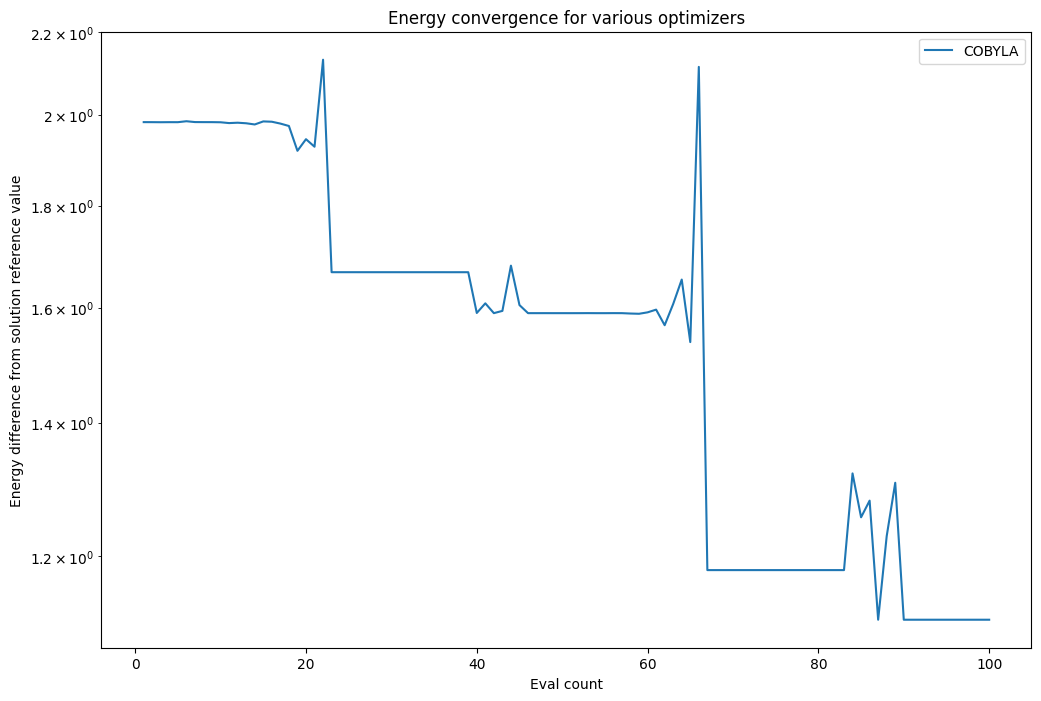

In [11]:
pylab.rcParams["figure.figsize"] = (12, 8)
for i, optimizer in enumerate(optimizers):
    pylab.plot(
        converge_counts[i],
        abs(ref_value - converge_vals[i]),
        label=type(optimizer).__name__,
    )
pylab.xlabel("Eval count")
pylab.ylabel("Energy difference from solution reference value")
pylab.title("Energy convergence for various optimizers")
pylab.yscale("log")
pylab.legend(loc="upper right");

In [12]:
# 第一步是初始化相应的基元和基元梯度：
from qiskit.algorithms.gradients import FiniteDiffEstimatorGradient

estimator = Estimator()
gradient = FiniteDiffEstimatorGradient(estimator, epsilon=0.01)

# 现在，您可以使用上面的 FiniteDiffEstimatorGradient 检查 SLSQP 运行：
algorithm_globals.random_seed = 50
# ansatz = TwoLocal(rotation_blocks="ry", entanglement_blocks="cz")
# ansatz = EfficientSU2(num_qubits, reps=2, entanglement='linear')
# optimizer = SLSQP(maxiter=100)
optimizer = COBYLA(maxiter = 1000)

counts = []
values = []


def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)


vqe = VQE(
    estimator, ansatz, optimizer, callback=store_intermediate_result, gradient=gradient
)

result = vqe.compute_minimum_eigenvalue(operator=hamiltonian)
print(f"Value using Gradient: {result.eigenvalue.real:.5f}")

C:\Users\18330\AppData\Local\Temp\ipykernel_6196\869211831.py:8: DeprecationWarning: The property ``qiskit.utils.algorithm_globals.QiskitAlgorithmGlobals.random_seed`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. This algorithm utility has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. You can run ``pip install qiskit_algorithms`` and import ``from qiskit_algorithms.utils`` instead. 
  algorithm_globals.random_seed = 50


KeyboardInterrupt: 

In [ ]:
pylab.rcParams["figure.figsize"] = (12, 8)
pylab.plot(counts, values, label=type(optimizer).__name__)
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Energy convergence using Gradient")
pylab.legend(loc="upper right");

In [ ]:
print(result)
cost_function_evals = result.cost_function_evals

In [ ]:
# 上面的结果中取出optimal_point并将其用作后续计算的initial_point
initial_pt = result.optimal_point

estimator1 = Estimator()
gradient1 = FiniteDiffEstimatorGradient(estimator, epsilon=0.01)
# ansatz1 = TwoLocal(rotation_blocks="ry", entanglement_blocks="cz")
# ansatz1 = EfficientSU2(num_qubits, reps=2, entanglement='linear')
ansatz1 = ansatz
optimizer1 = COBYLA(maxiter=1000)

vqe1 = VQE(
    estimator1, ansatz1, optimizer1, gradient=gradient1, initial_point=initial_pt
)
result1 = vqe1.compute_minimum_eigenvalue(operator=hamiltonian)
print(result1)

cost_function_evals1 = result1.cost_function_evals
print(
    f"cost_function_evals is {cost_function_evals1} with initial point versus {cost_function_evals} without it."
)

In [ ]:
from qiskit import transpile, assemble, Aer

optimized_params = result1.optimal_point
optimized_ansatz = ansatz1.bind_parameters(optimized_params)
backend = Aer.get_backend('statevector_simulator')
# 对每个量子比特进行测量
# for i in range(num_qubits):
#     measuring_circuit = optimized_ansatz.copy()
#     measuring_circuit.measure(i, 0)
#     job = execute(measuring_circuit, backend, shots=1024)
#     counts = job.result().get_counts()
#     # 计算 <Z_i>
#     expectation_z = (counts.get('0', 0) - counts.get('1', 0)) / 1024
#     print(f"<Z_{i}> = {expectation_z}")
optimized_ansatz.measure_all()
job = sampler.run(optimized_ansatz,shots=10000)
result = job.result()
quasi_dist = result.quasi_dists[0]
counts = quasi_dist.binary_probabilities()
print(counts)
# backend = Aer.get_backend('qasm_simulator')
# transpiled_circuit = transpile(optimized_ansatz, backend)
# print(transpiled_circuit.draw())
# qobj = assemble(transpiled_circuit, backend, shots=10000)
#
# # Execute the circuit on the simulator
# result = execute(transpiled_circuit, backend, shots=10000).result()
# # print(result)
# # Get the measurement results
# counts = result.get_counts(transpiled_circuit)
# print("Measurement results:", counts)

In [ ]:
# 测量结果
# measurement_result = '000011110100'
measurement_result = '000011110000'
# 将测量结果转换为+1和-1
def measurement_to_expectation(measurement):
    return np.array([-1 if bit == '1' else 1 for bit in measurement])

# 计算每个项的期望值并累加
def calculate_energy(hamiltonian, measurement_result):
    energy = 0.0
    expectation_values = measurement_to_expectation(measurement_result)

    for pauli, coeff in zip(hamiltonian.paulis.to_labels(), hamiltonian.coeffs):
        term_value = 1.0
        for idx, pauli_char in enumerate(pauli):
            if pauli_char == 'Z':
                term_value *= expectation_values[idx]
        energy += coeff * term_value

    return energy

# 计算并输出能量
energy = calculate_energy(hamiltonian, measurement_result)
print(f"Energy for measurement result {measurement_result}: {energy}")